In [24]:

import time

import matplotlib.pyplot as plt

import numpy as np
from easyscience.Datasets.xarray import xr
import scipp as sc


nx = 5E3
x_min = 0
x_max = 3*np.pi

# x = np.linspace(x_min, x_max, num=int(nx))
x=sc.linspace('x',x_min,x_max,num=int(nx),unit='rad')
y=sc.sin(x)
y.name='y'
d=sc.DataArray(data=y,coords={'x':x})
sc.plot(d)
d


<scipp.DataArray>
Dimensions: Sizes[x:5000, ]
Coordinates:
* x                         float64            [rad]  (x)  [0, 0.00188533, ..., 9.42289, 9.42478]
Data:
                            float64  [dimensionless]  (x)  [0, 0.00188533, ..., 0.00188533, 3.67394e-16]

In [ ]:

# d=sc.DataArray()


d = xr.Dataset()
d.easyscience.add_coordinate('x', x)
d.easyscience.add_variable('y', ['x'], np.sin(x), auto_sigma=False)

d['y'].plot()
plt.show()


In [2]:


d.easyscience.remove_variable('y')
d.easyscience.add_coordinate('y', x + np.pi)
d.easyscience.add_variable('z', ['x', 'y'], np.sin(x).reshape((-1, 1))*np.cos(x).reshape((1, -1)) + (0.5 - np.random.random(size=(int(nx), int(nx)))))

In [3]:

def func(x, *args, **kwargs):
    return np.sin(x[:, 0]) * np.cos(x[:, 1])


In [4]:

bdims, f = d['z'].easyscience.fit_prep(func)
d['x_broadcast'], d['y_broadcast'] = bdims

d

<xarray.Dataset> Size: 600MB
Dimensions:      (x: 5000, y: 5000)
Coordinates:
  * x            (x) float64 40kB 0.0 0.001885 0.003771 ... 9.421 9.423 9.425
  * y            (y) float64 40kB 3.142 3.143 3.145 3.147 ... 12.56 12.56 12.57
Data variables:
    z            (x, y) float64 200MB 0.1199 -0.2046 0.3237 ... -0.2535 0.4248
    x_broadcast  (x, y) float64 200MB 0.0 0.0 0.0 0.0 ... 9.425 9.425 9.425
    y_broadcast  (x, y) float64 200MB 3.142 3.143 3.145 ... 12.56 12.56 12.57
Attributes:
    name:         
    description:  
    url:          
    units:        {'x': <Unit('dimensionless')>, 'y': <Unit('dimensionless')>...

Applying func - No dask
Time taken: 0.6034150123596191


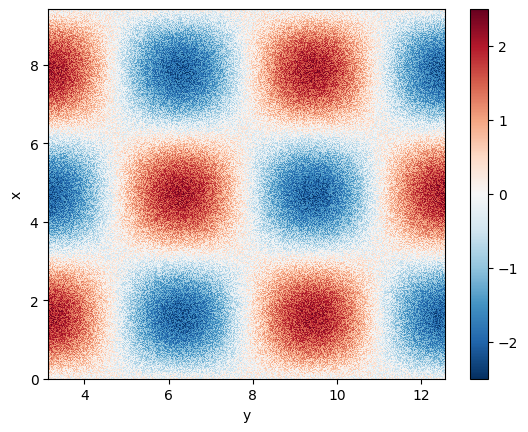

Applying func - Dask
Time taken: 1.3313887119293213


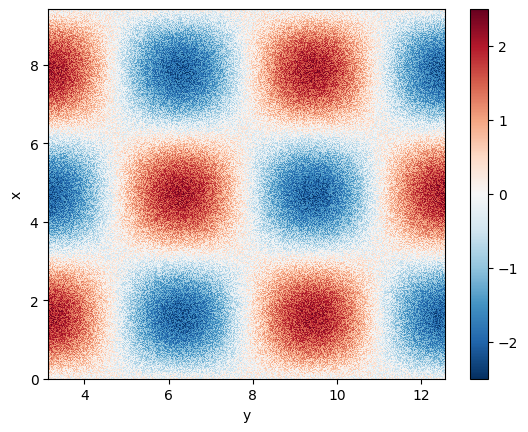

All done :-)


In [5]:

print('Applying func - No dask')
t = time.time()
d['computed_no_dask'] = xr.apply_ufunc(f, d['x_broadcast'], d['y_broadcast'])
temp = d['z'] - d['computed_no_dask']
print(f'Time taken: {time.time() - t}')
temp.plot()
plt.show()

print('Applying func - Dask')
t = time.time()
to_chunk = ['x_broadcast', 'y_broadcast', 'z']
for name in to_chunk:
    d[name] = d[name].chunk({'x': 4000, 'y': 4000})
d['computed_dask'] = xr.apply_ufunc(f, d['x_broadcast'], d['y_broadcast'], dask='parallelized')
temp = d['z'] - d['computed_dask']
temp.compute()
print(f'Time taken: {time.time() - t}')
temp.plot()
plt.show()

print('All done :-)')
